In [3]:
# Installing the required python libraries into the Colab Workspace
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install numpy
%pip install scikit-learn
%pip install tensorflow



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing the relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


RESET = "\033[0m"
RED = "\033[91m"
GREEN = "\033[92m"
BLUE = "\033[94m"

In [5]:
# Importing the combined dataset exported from task 02
combined_df = pd.read_csv("Datasets/task_02_export.csv")

In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9604 entries, 0 to 9603
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9604 non-null   object 
 1   Location       9604 non-null   object 
 2   Precipitation  9604 non-null   float64
 3   Temperature    9604 non-null   float64
 4   Wind Speed     8128 non-null   float64
 5   Elevation      9604 non-null   float64
 6   HCHO_reading   9604 non-null   float64
dtypes: float64(5), object(2)
memory usage: 525.3+ KB


In [7]:
combined_df.describe()

,Precipitation,Temperature,Wind Speed,Elevation,HCHO_reading
count,9604.000000,9604.000000,8128.000000,9604.000000,9604.000000
mean,5.020463,24.922845,15.669291,379.379217,0.000119
std,5.994828,4.165751,6.723410,368.573022,0.000050
min,0.062000,14.400000,5.600000,3.000000,0.000032
25%,1.600000,23.500000,10.400000,5.000000,0.000079
50%,2.900000,26.400000,14.800000,263.000000,0.000112
75%,5.300000,27.800000,19.100000,621.000000,0.000155
max,41.900000,30.000000,39.000000,1093.000000,0.000277


In [8]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Create new features from the 'Date' column
combined_df['Year'] = combined_df['Date'].dt.year
combined_df['Month'] = combined_df['Date'].dt.month
combined_df['Day'] = combined_df['Date'].dt.day
combined_df['DayOfWeek'] = combined_df['Date'].dt.dayofweek
combined_df['Hour'] = combined_df['Date'].dt.hour

# Create lagged features from the 'HCHO_reading' column
combined_df['HCHO_reading_lag1'] = combined_df['HCHO_reading'].shift(1)
combined_df['HCHO_reading_lag2'] = combined_df['HCHO_reading'].shift(2)

# Drop missing values introduced by the 'shift' function
combined_df = combined_df.dropna()

In [9]:
# Label encoding the textual / categorical data
for column in combined_df.columns:
    if combined_df[column].dtypes == "object":
        label_encoder = sklearn.preprocessing.LabelEncoder()
        combined_df[column] = label_encoder.fit_transform(combined_df[column])
combined_df

,Date,Location,Precipitation,Temperature,Wind Speed,Elevation,HCHO_reading,Year,Month,Day,DayOfWeek,Hour,HCHO_reading_lag1,HCHO_reading_lag2
2,2019-01-03,1,3.8,27.1,16.0,5.0,0.000099,2019,1,3,3,0,0.000263,0.000197
3,2019-01-04,1,3.8,27.1,16.9,5.0,0.000210,2019,1,4,4,0,0.000099,0.000263
4,2019-01-05,1,3.8,27.2,16.8,5.0,0.000179,2019,1,5,5,0,0.000210,0.000099
5,2019-01-06,1,3.8,27.4,16.0,5.0,0.000108,2019,1,6,6,0,0.000179,0.000210
6,2019-01-08,1,3.8,27.6,13.7,5.0,0.000092,2019,1,8,1,0,0.000108,0.000179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9599,2023-12-27,4,2.9,23.4,11.1,621.0,0.000082,2023,12,27,2,0,0.000090,0.000099
9600,2023-12-28,4,2.9,23.4,11.1,621.0,0.000073,2023,12,28,3,0,0.000082,0.000090
9601,2023-12-29,4,2.9,23.4,11.1,621.0,0.000065,2023,12,29,4,0,0.000073,0.000082
9602,2023-12-30,4,2.9,23.4,11.1,621.0,0.000056,2023,12,30,5,0,0.000065,0.000073


In [10]:
# Feature scaling the dataset
feature_scaler = MinMaxScaler()
feature_scaled_data = feature_scaler.fit_transform(combined_df.drop('Date', axis=1))
feature_scaled_data = pd.DataFrame(feature_scaled_data, columns=combined_df.drop('Date', axis=1).columns)
feature_scaled_data

,Location,Precipitation,Temperature,Wind Speed,Elevation,HCHO_reading,Year,Month,Day,DayOfWeek,Hour,HCHO_reading_lag1,HCHO_reading_lag2
0,0.2,0.089345,0.641975,0.311377,0.003236,0.269157,0.0,0.0,0.066667,0.500000,0.0,0.942027,0.673058
1,0.2,0.089345,0.641975,0.338323,0.003236,0.726174,0.0,0.0,0.100000,0.666667,0.0,0.269157,0.942027
2,0.2,0.089345,0.654321,0.335329,0.003236,0.597376,0.0,0.0,0.133333,0.833333,0.0,0.726174,0.269157
3,0.2,0.089345,0.679012,0.311377,0.003236,0.308982,0.0,0.0,0.166667,1.000000,0.0,0.597376,0.726174
4,0.2,0.089345,0.703704,0.242515,0.003236,0.240485,0.0,0.0,0.233333,0.166667,0.0,0.308982,0.597376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8121,0.8,0.067833,0.185185,0.164671,1.000000,0.200530,1.0,1.0,0.866667,0.333333,0.0,0.235931,0.271332
8122,0.8,0.067833,0.185185,0.164671,1.000000,0.165128,1.0,1.0,0.900000,0.500000,0.0,0.200530,0.235931
8123,0.8,0.067833,0.185185,0.164671,1.000000,0.129727,1.0,1.0,0.933333,0.666667,0.0,0.165128,0.200530
8124,0.8,0.067833,0.185185,0.164671,1.000000,0.094326,1.0,1.0,0.966667,0.833333,0.0,0.129727,0.165128


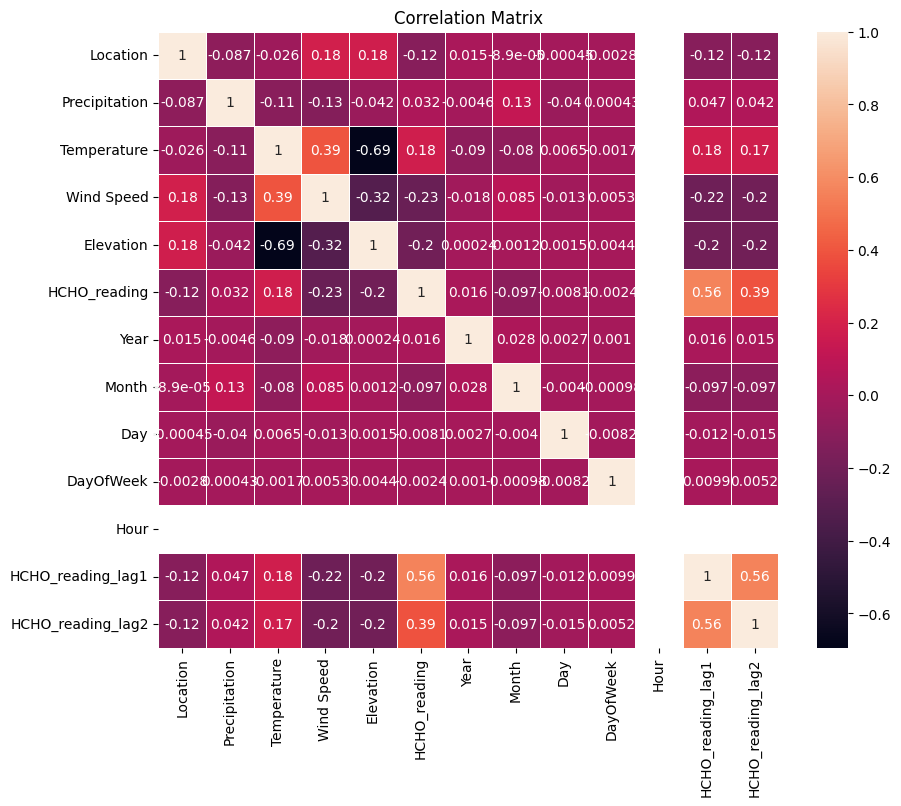

In [11]:
correlation_matrix = feature_scaled_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [12]:
# Seperating the independant features from the target
independant_df = feature_scaled_data.drop("HCHO_reading", axis = 1)
dependant_df = feature_scaled_data["HCHO_reading"]

# Running the correlation matrix to find the most affecting values
sorted_attributes = abs(feature_scaled_data.corr()["HCHO_reading"]).sort_values()

# Removing the least influencing values
for i in range(len(sorted_attributes)):
    if sorted_attributes.iloc[i] < 0.03:
        feature_to_remove = sorted_attributes.index[i]
        independant_df = independant_df.drop(feature_to_remove, axis=1)
        print(f"The column {feature_to_remove} is being removed since its absolute correlation with income is {sorted_attributes.iloc[i].round(2)}.")

The column DayOfWeek is being removed since its absolute correlation with income is 0.0.
The column Day is being removed since its absolute correlation with income is 0.01.
The column Year is being removed since its absolute correlation with income is 0.02.


In [13]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(independant_df, dependant_df, test_size=0.2, random_state=42)

In [14]:
# FORECASTING USING LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=2)

# Evaluate the LSTM model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

Epoch 1/200


/Users/vinodwijetilleke/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


204/204 - 1s - 5ms/step - loss: 0.0472
Epoch 2/200
204/204 - 0s - 1ms/step - loss: 0.0333
Epoch 3/200
204/204 - 0s - 1ms/step - loss: 0.0310
Epoch 4/200
204/204 - 0s - 1ms/step - loss: 0.0304
Epoch 5/200
204/204 - 0s - 2ms/step - loss: 0.0298
Epoch 6/200
204/204 - 0s - 1ms/step - loss: 0.0293
Epoch 7/200
204/204 - 0s - 1ms/step - loss: 0.0291
Epoch 8/200
204/204 - 0s - 1ms/step - loss: 0.0290
Epoch 9/200
204/204 - 0s - 2ms/step - loss: 0.0289
Epoch 10/200
204/204 - 0s - 1ms/step - loss: 0.0287
Epoch 11/200
204/204 - 0s - 1ms/step - loss: 0.0287
Epoch 12/200
204/204 - 0s - 1ms/step - loss: 0.0288
Epoch 13/200
204/204 - 0s - 1ms/step - loss: 0.0288
Epoch 14/200
204/204 - 0s - 1ms/step - loss: 0.0287
Epoch 15/200
204/204 - 0s - 1ms/step - loss: 0.0287
Epoch 16/200
204/204 - 0s - 1ms/step - loss: 0.0285
Epoch 17/200
204/204 - 0s - 1ms/step - loss: 0.0285
Epoch 18/200
204/204 - 0s - 2ms/step - loss: 0.0286
Epoch 19/200
204/204 - 0s - 2ms/step - loss: 0.0286
Epoch 20/200
204/204 - 0s - 1ms/s

/Users/vinodwijetilleke/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


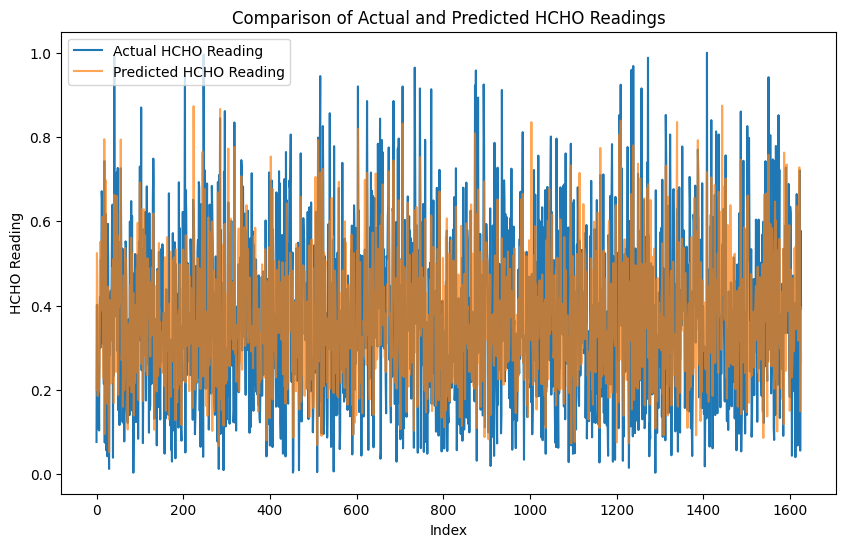

In [15]:
# Plotting the actual VS predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual HCHO Reading')
plt.plot(y_pred, label='Predicted HCHO Reading', alpha=0.7)
plt.title('Comparison of Actual and Predicted HCHO Readings')
plt.xlabel('Index')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()


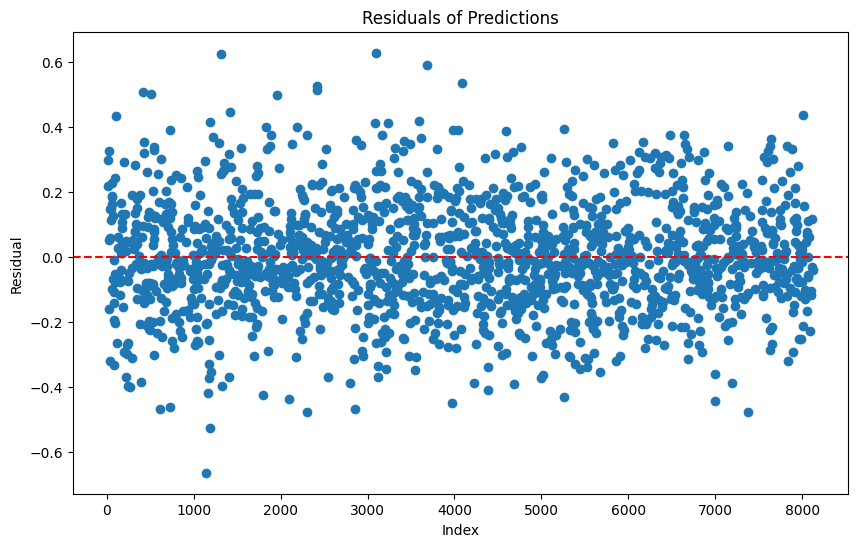

In [16]:
# Plotting the residuals
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of Predictions')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.show()


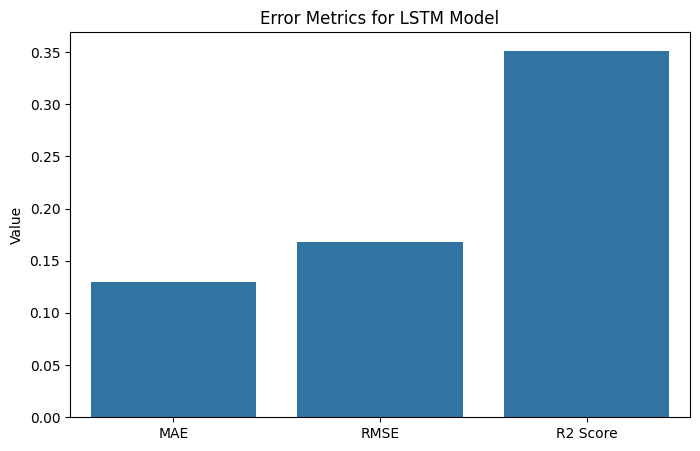

In [17]:
# Plotting the error metrics
errors = {'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(errors.keys()), y=list(errors.values()))
plt.title('Error Metrics for LSTM Model')
plt.ylabel('Value')
plt.show()


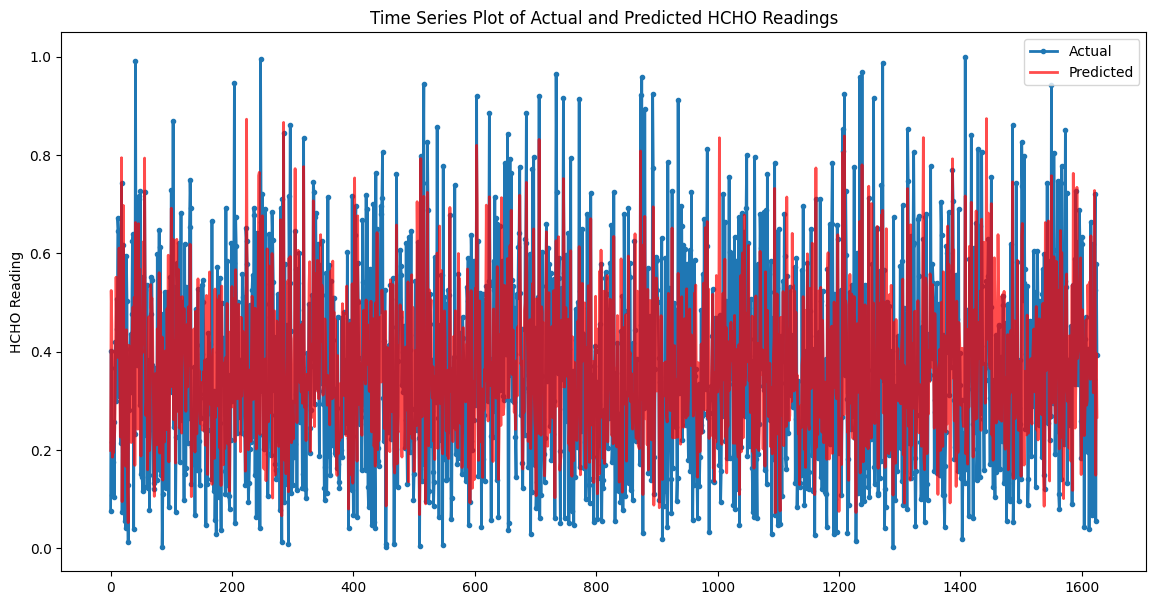

In [18]:
# Plotting the actual VS predicted values along a time period
fig, ax = plt.subplots(figsize=(14, 7))
time_index = range(len(y_test)) 
ax.plot(time_index, y_test, marker='.', label="Actual", linewidth=2)
ax.plot(time_index, y_pred, 'r', label="Predicted", linewidth=2, alpha=0.7)
ax.set_ylabel('HCHO Reading')
ax.set_title('Time Series Plot of Actual and Predicted HCHO Readings')
ax.legend()
plt.show()


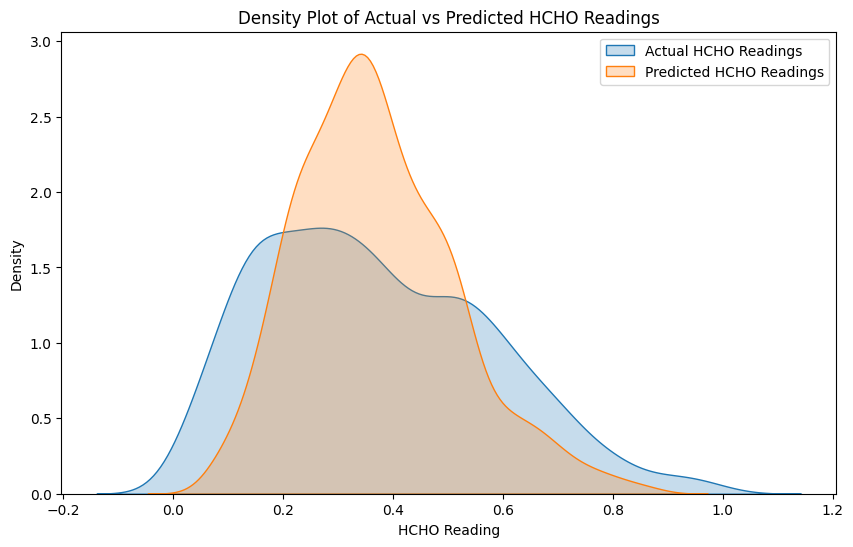

In [19]:
# Plotting the density of predicted VS actual values
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual HCHO Readings', fill=True)
sns.kdeplot(y_pred.flatten(), label='Predicted HCHO Readings', fill=True)
plt.title('Density Plot of Actual vs Predicted HCHO Readings')
plt.xlabel('HCHO Reading')
plt.legend()
plt.show()


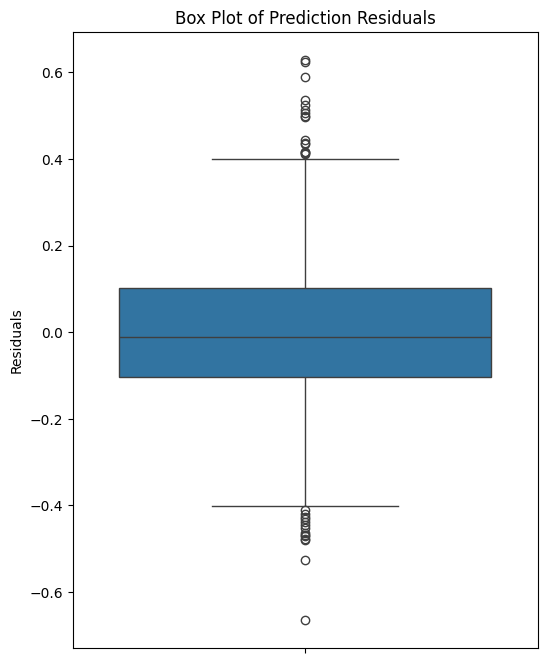

In [20]:
# Plotting the spreads of residuals
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(6, 8))
sns.boxplot(y=residuals)
plt.title('Box Plot of Prediction Residuals')
plt.ylabel('Residuals')
plt.show()


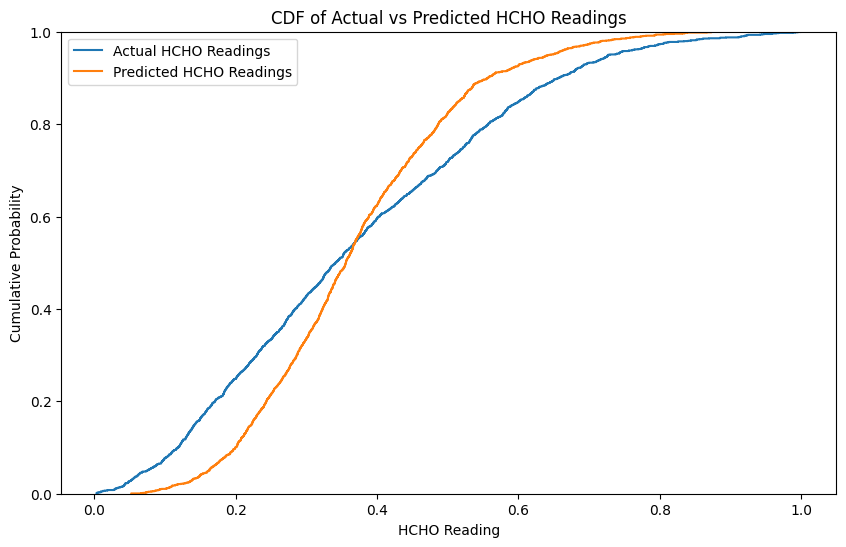

In [21]:
# Cumulative distribution function
plt.figure(figsize=(10, 6))
sns.ecdfplot(y_test, label='Actual HCHO Readings')
sns.ecdfplot(y_pred.flatten(), label='Predicted HCHO Readings')
plt.title('CDF of Actual vs Predicted HCHO Readings')
plt.xlabel('HCHO Reading')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()


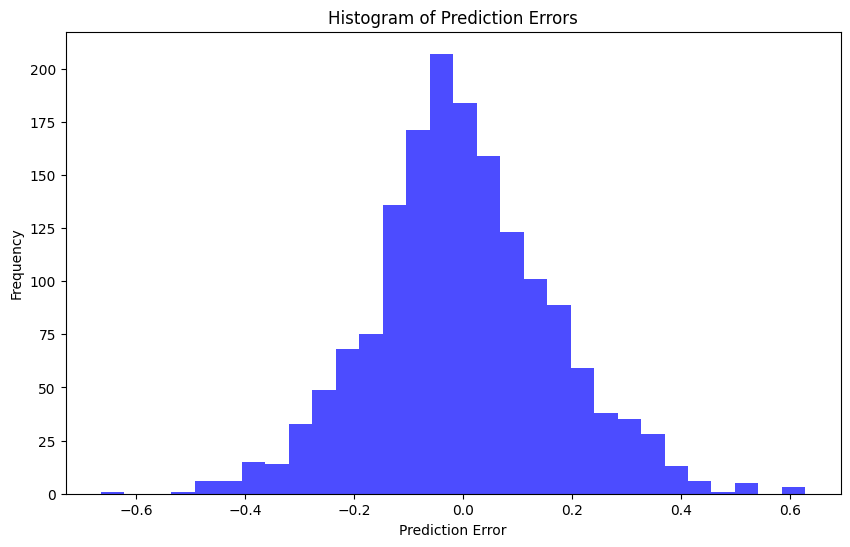

In [22]:
# Histogram of prediction errors
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


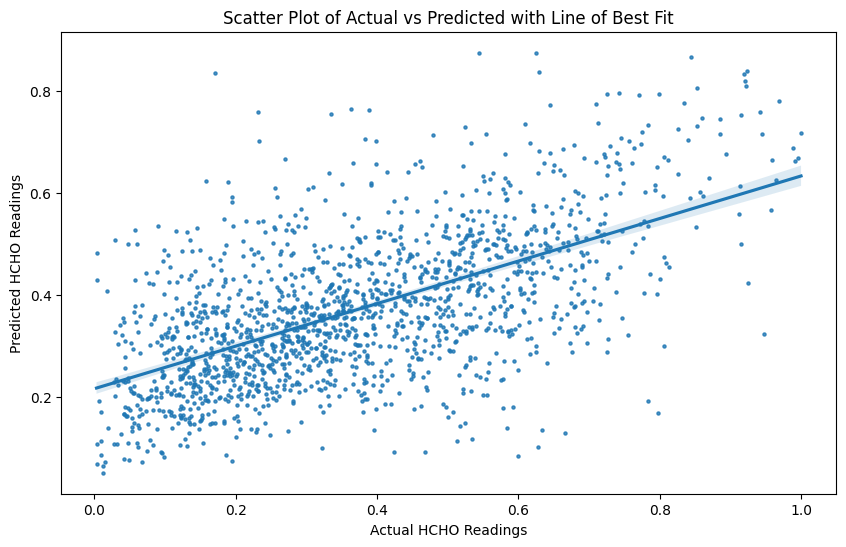

In [23]:
# Plotting the line of best fit
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred.flatten(), scatter=True, fit_reg=True, scatter_kws={'s': 5})
plt.title('Scatter Plot of Actual vs Predicted with Line of Best Fit')
plt.xlabel('Actual HCHO Readings')
plt.ylabel('Predicted HCHO Readings')
plt.show()


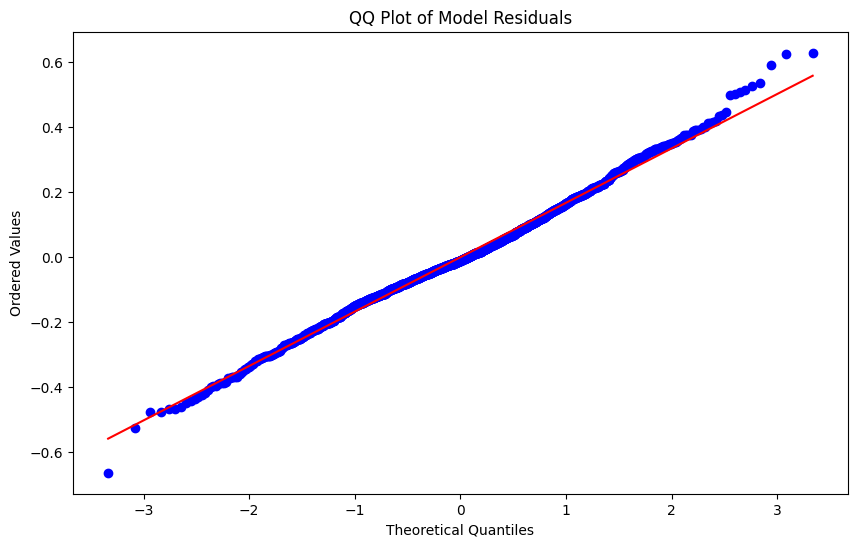

In [24]:
# Plot to assess the normality of residuals
from scipy import stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Model Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()
